In [1]:
import lime,shap
shap.initjs()
import xgboost as xgb
import lightgbm as lgb
import sklearn
import numpy as np
import pandas as pd
import sklearn.ensemble
import sklearn.metrics
from sklearn.datasets import load_iris
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
feature_names = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss","Hours per week", "Country"]
data = np.genfromtxt('adult.data', delimiter=', ', dtype=str)
data = pd.DataFrame(data, columns=feature_names+['label'])

In [3]:
labels = data.iloc[:,14]
le= LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
# data = data[:,:-1]

categorical_features = [1,3,5, 6,7,8,9,13]

categorical_names = {}
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data.iloc[:, feature])
    data.iloc[:, feature] = le.transform(data.iloc[:, feature])
    categorical_names[feature] = le.classes_
    
data[feature_names] = data[feature_names].astype(float)
encoder = OneHotEncoder(categorical_features=categorical_features)

In [4]:
np.random.seed(1)
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(data[feature_names], labels, train_size=0.80)

# encoder.fit(data)
# encoded_train = encoder.transform(train)
# encoded_test = encoder.transform(test)

gbtree = xgb.XGBClassifier(n_estimators=2000, max_depth=4, learning_rate=0.05, n_jobs=8)
gbtree.fit(train, labels_train,eval_set=[(test, labels_test)], eval_metric='auc', verbose=100, early_stopping_rounds=100)

/home/linxid/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[0]	validation_0-auc:0.868147
Will train until validation_0-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.914365
[200]	validation_0-auc:0.921417
[300]	validation_0-auc:0.92369
[400]	validation_0-auc:0.924009
[500]	validation_0-auc:0.924338
[600]	validation_0-auc:0.924608
[700]	validation_0-auc:0.924968
[800]	validation_0-auc:0.92494
Stopping. Best iteration:
[749]	validation_0-auc:0.925074



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=2000, n_jobs=8, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [5]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(gbtree)
shap_values = explainer.shap_values(test)

# 对一个样本求shap值，各个特征对output所带来的变化
shap.force_plot(explainer.expected_value, shap_values[16,:], test.iloc[16,:])

In [6]:
shap.force_plot(explainer.expected_value, shap_values[10,:], test.iloc[10,:])

In [7]:
# 将上述图像旋转90度，对整个样本求shap值
shap.force_plot(explainer.expected_value, shap_values, test)

/home/linxid/anaconda3/envs/python36/lib/python3.6/site-packages/shap/plots/force.py:145: UserWarning: shap.force_plot is slow for many thousands of rows, try subsampling your data.
  warnings.warn("shap.force_plot is slow for many thousands of rows, try subsampling your data.")


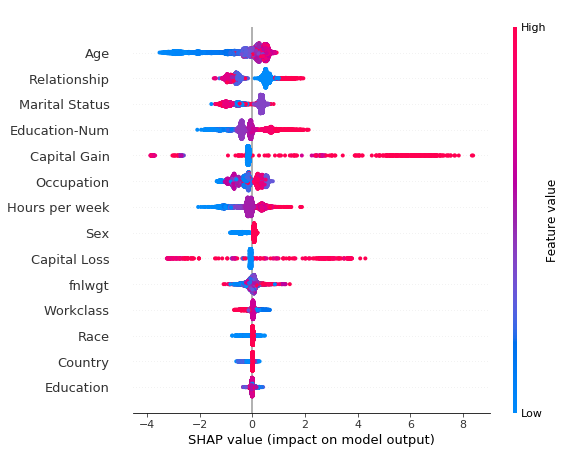

In [57]:
shap.summary_plot(shap_values, test)

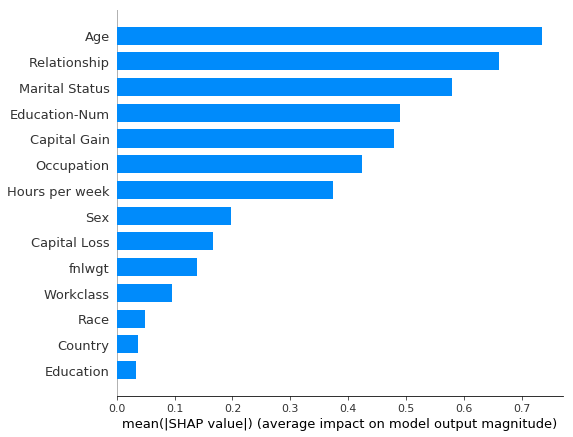

In [65]:
shap.summary_plot(shap_values, test, plot_type='bar')

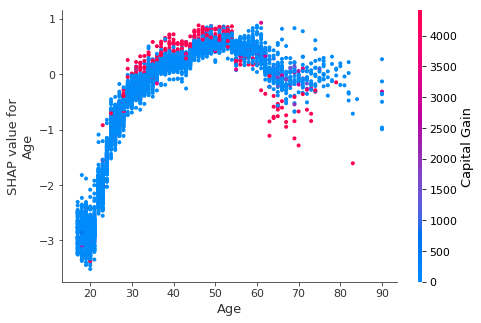

In [64]:
shap.dependence_plot("Age", shap_values, test)

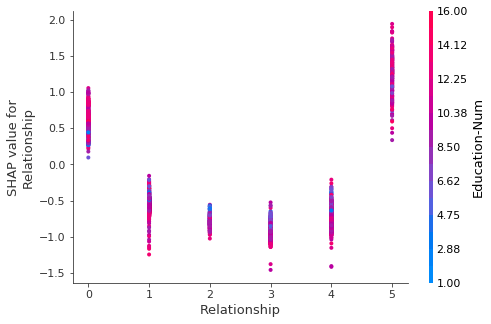

In [67]:
shap.dependence_plot("Relationship", shap_values, test)

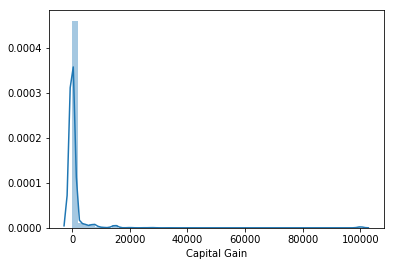

In [60]:
import seaborn as sns
sns.distplot(data['Capital Gain'])

In [4]:

# train XGBoost model
X,y = shap.datasets.boston()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 5000, evals = [(xgb_test, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:3.67326
[1000]	test-cox-nloglik:3.07014
[2000]	test-cox-nloglik:2.94685
[3000]	test-cox-nloglik:2.87879
[4000]	test-cox-nloglik:2.83538
[4999]	test-cox-nloglik:2.81375


In [6]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model_train)
shap_values = explainer.shap_values(X)

# 对一个样本求shap值，各个特征对output所带来的变化
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [7]:
# 将上述图像旋转90度，对整个样本求shap值
shap.force_plot(explainer.expected_value, shap_values, X)

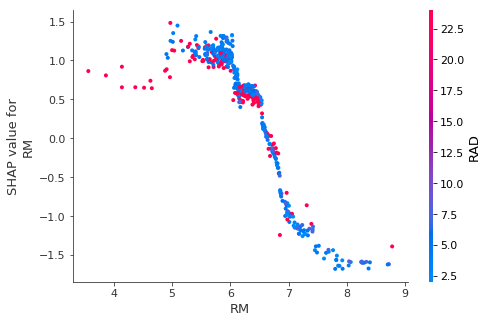

In [8]:
# 求单个特征对输出的影响，会自动选择一个特征，在当前特征值不变时，所带来的影响（是否有一个指标衡量两个特征的结合程度，为什么要选择这两个特征结合,有什么指导思想）
shap.dependence_plot("RM", shap_values, X)

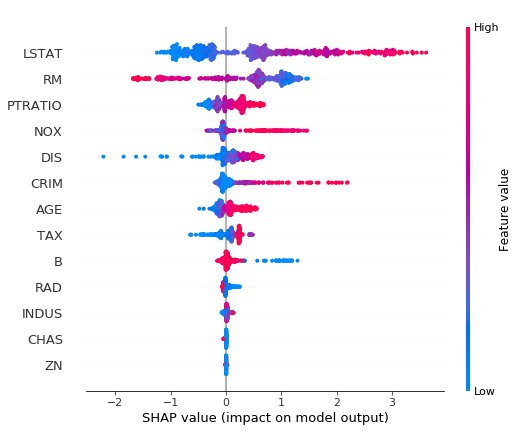

In [9]:
# 观察全部特征对输出的影响，但是同一个特征竖直的波动是什么意思呢
shap.summary_plot(shap_values, X)

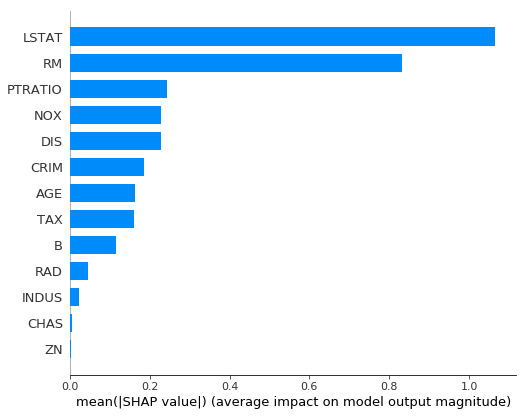

In [10]:
# 每个特征，在每个样本得到的对输出的影响，求平均值，得到类似lgb特征重要性的一个柱状图
shap.summary_plot(shap_values, X, plot_type="bar")

In [11]:
import sklearn
import shap
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

/home/linxid/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
Using 120 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


/home/linxid/anaconda3/envs/python36/lib/python3.6/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/linxid/anaconda3/envs/python36/lib/python3.6/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/linxid/anaconda3/envs/python36/lib/python3.6/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and

/home/linxid/anaconda3/envs/python36/lib/python3.6/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/linxid/anaconda3/envs/python36/lib/python3.6/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/linxid/anaconda3/envs/python36/lib/python3.6/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and

In [10]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")